# Deep learning for galaxy deblending

> Author: Alexandre Boucaud (APC, CNRS)  
> Email: <aboucaud@apc.in2p3.fr>

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Detection-evaluation)
5. [Local testing/exploration](#Local-testing)

## Introduction

In astronomical images, the projection effects may cause two or more galaxies to overlap. When they are barely indistinguishable from one another, they are referred to as _blended_ and this can bias astrophysical estimators such as the morphology of galaxies or the shear (weak gravitational lensing distortion).  
As the sensitivity of imaging devices grows, a high fraction of galaxies appear _blended_ in the images, which is a known and important issue for current and upcoming galaxy surveys.  

In order not to discard such a wealth of information, it is key to develop methods to enable astronomers to alleviate such effect.
We can foresee some features that would help, in which machine learning could provide a solution:
- classify an image as containing isolated/blended objects  
  ___binary classification___
- count the number of blended sources in a blended image  
  ___regression / object detection___
- find the contours of each object  
  ___object detection/segmentation___
- ...

In this exercice, we will approach the third item, the detection of contours, but in a constrained way : the images will only contain **two galaxies** and the goal will be to find the **contours of the central galaxy**.

In [ ]:
!pip uninstall dltools  --yes

In [ ]:
# Install the `dltools` lib that contains helper methods for training a deep neural network on the provided blended galaxy dataset.
!pip install git+https://github.com/ASKabalan/deeplearning4astro_tools

In [ ]:
## Necessary imports

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from dltools.detector import ObjectDetector
from dltools.metric import iou_bitmap
from dltools.plots import plot_history
from dltools.plots import plot_random_results

In [ ]:
ObjectDetector??

## Data

In [ ]:
use_big_data = True
# use_big_data = False  # uncomment the line if running on a machine without GPU.
suffix = "" if use_big_data else "_mini"

In [ ]:
# Download the data
# This will fetch the data files from the APC server and unpack them into the `data` directory.

datadir = "data"

import sys
import tarfile
from urllib.request import urlretrieve

URL = "https://www.apc.univ-paris7.fr/Downloads/comput/aboucaud"
FOLDER = "ed127"
FILES = [
    "test_blends_mini.npy",
    "test_target_masks_2_mini.npy",
    "train_blends_mini.npy",
    "train_target_masks_2_mini.npy",

]
BIG_FILES = [
    "masks2.tar.gz",
    "blends.tar.gz",
]

def download_data(output_dir, use_big_data=False):
    if use_big_data:
        files = BIG_FILES
    else:
        files = FILES

    urls = [
        f"{URL}/{FOLDER}/{filename}"
        for filename in files
    ]

    if not os.path.exists(output_dir):
        print(f"Creating directory {output_dir}")
        os.mkdir(output_dir)

    for url, filename in zip(urls, files):
        output_file = os.path.join(output_dir, filename)

        if os.path.exists(output_file):
            print(f"{filename} already downloaded.")
            continue

        print(f"Downloading from {url} ...")
        urlretrieve(url, filename=output_file)
        print(f"=> File saved as {output_file}")

        if filename.endswith("tar.gz"):
            print("Extracting tarball..")
            with tarfile.open(output_file, "r:gz") as f:
                f.extractall(output_dir)
            print("Done.")

download_data(output_dir=datadir, use_big_data=use_big_data)

Creating directory data
=> File saved as data/masks2.tar.gz
Extracting tarball..
Done.
=> File saved as data/blends.tar.gz
Extracting tarball..
Done.


## Load data

Load the train and test datasets in memory-mapping mode. This does not actually load the data into memory but creates a mapping to it to easily retrieve chunks of the data using its indices when needed.

In [ ]:
X_train = np.load(os.path.join(datadir, f"train_blends{suffix}.npy"), mmap_mode='r')
Y_train = np.load(os.path.join(datadir, f"train_target_masks_2{suffix}.npy"), mmap_mode='r')

X_test = np.load(os.path.join(datadir, f"test_blends{suffix}.npy"), mmap_mode='r')
Y_test = np.load(os.path.join(datadir, f"test_target_masks_2{suffix}.npy"), mmap_mode='r')

In [ ]:
def plot_data_basic(idx):
    titles = [
        'blended galaxies',
        'segmap of companion galaxy'
    ]

    fig_size = (12, 6)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
    axes[0].imshow(X_train[idx], cmap='viridis')
    axes[1].imshow(Y_train[idx], cmap='Greys_r')
    for title, ax in zip(titles, axes):
        ax.set_title(title)
        ax.set_axis_off()

1101


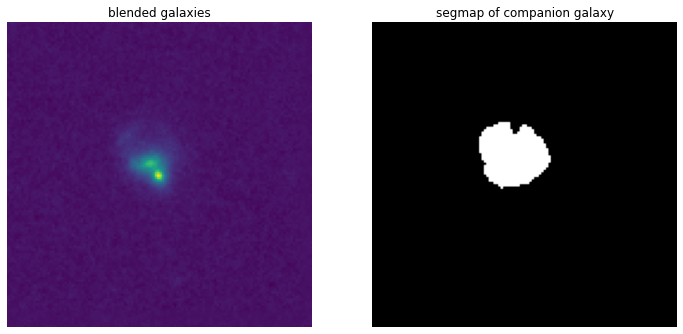

In [ ]:
index = np.random.randint(len(X_train))
print(index)
plot_data_basic(index)

The goal in this exercise is to create a deep learning model that produces the segmentation map (mask) of the companion galaxy from the image of the blend. This can be seen as a classification task where each pixel of the image has to be classified as "galaxy companion" or "not galaxy companion".

## Workflow

In the `dltools` package we have implemented a class called `ObjectDetector`, with two main methods implemented : `fit()` and `predict()`

However `ObjectDetector` is missing a model that **you need to provide**. You can have a look at how the ObjectDetector was implemented to run your model. It will give you an idea of how to organize your code.

In [ ]:
# too much text
ObjectDetector??

The model needs to take the image blend as input and produce an other image as output.

## Detection evaluation

For image detection a classical metric is the ***Intersection over Union (IoU)*** also referred to as ***Jaccard index*** and defined as

$$ IoU(A, B) =  \dfrac{|A \cap B|}{|A \cup B|} $$

This metric is very sensitive to small shifts or area difference between truth and prediction.

Typically, a value of IoU superior to 0.5 is used to define a good detection.

An implementation of the IoU for a series of flatten segmentation images $\in [0, 1]$ can be found in

In [ ]:
# too much text
#iou_bitmap??

This is the metric used to score the segmentation.

## Model

The model is the part where you intervention is needed. A very basic (working) model is implemented below. It has two convolution layers. While it is very fast to train, it does not yield good results.

Try to navigate the web/github to find appropriate models for this image segmentation task. Or build upon this existing model by complexifying it.

In [ ]:
# You may need some more imports here
# ===================================
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
tf.autograph.set_verbosity(0)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    Dropout,
    Input,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    UpSampling2D,
    Concatenate
)
from tensorflow.keras.layers import GaussianNoise

input_shape = (128, 128, 1)  # input images are 128 x 128 with a single channel
output_channels = 1          # we want a single image as output
last_activation = "sigmoid"  # to get the output values between 0 and 1

TensorFlow version:  2.8.2


In [ ]:
# This is were you need to upgrade the model
# ==========================================
input_shape = (128, 128, 1)
output_channels = 1
depth = 32
n_layers = 7 #5
conv_size0 = (3, 3)
conv_size = (3, 3)
last_conv_size = (3, 3)
activation = "relu"
last_activation = "sigmoid"
dropout_rate = 0.5 #0.3
sigma_noise = 0.01

def convmodel():
    model = Sequential()

    # first layer
    model.add(Conv2D(depth, conv_size0, input_shape=input_shape, activation=activation, padding="same", name="conv0"))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # middle layer
    for layer_n in range(1, n_layers):
        model.add(Conv2D(depth, conv_size, activation=activation, padding="same", name="conv{}".format(layer_n)) )

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    if sigma_noise > 0:
        model.add(GaussianNoise(sigma_noise))

    # last layer
    model.add(Conv2D(output_channels, last_conv_size, activation=last_activation, padding="same", name="last"))

    return model

In [ ]:
input_shape = (128, 128, 1)
output_channels = 1
depths = [8, 16, 16, 32, 64]
dropout_rate = 0.5
sigma_noise = 0.01

def autoencoder():
    model_input = Input(shape=input_shape)

    # Encoder
    for i, depth in enumerate(depths):
        if i == 0:
            x = Conv2D(depth, 3, activation="relu", padding="same", name="Encoder_conv{}".format(i))(model_input)
        else:
            x = Conv2D(depth, 3, activation="relu", padding="same", name="Encoder_conv{}".format(i))(x)
            x = MaxPooling2D(2)(x)
            if dropout_rate > 0:
                x = Dropout(dropout_rate)(x)

    # Decoder
    for i, depth in enumerate(reversed(depths)):
        x = Conv2D(depth, 3, activation="relu", padding="same", name="Decoder_conv{}".format(i))(x)
        if i < len(depths) - 1:
            x = UpSampling2D(2)(x)

        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    if sigma_noise > 0:
        x = GaussianNoise(sigma_noise)(x)

    # last layer
    model_output = Conv2D(output_channels, 3, activation="sigmoid", padding="same", name="last")(x)

    model = Model(model_input, model_output)

    return model

In [ ]:
input_shape = (128, 128, 1)
output_channels = 1
sigma_noise = 0.01
channels_list = [8, 16, 32, 32, 64 , 128]
#channels_list = [32, 32, 64, 128]

def unet():
    unet_input = Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = Conv2D(n_channels, 3, activation='relu', padding='same', name=f'Encoder_conv_{i}')(x)
        list_features.append((n_channels, x))
        x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        x = UpSampling2D(2)(x)
        x = Concatenate(axis=-1)([x, same_reso_features])
        x = Conv2D(n_channels, 3, activation='relu', padding='same', name=f'Decoder_conv_{i}')(x)

    if sigma_noise > 0:
            x = GaussianNoise(sigma_noise)(x)

    unet_output = Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = Model(unet_input, unet_output, name='unet')

    return model

#### Vérifier avec le `summary()` que la sortie du modèle correspond bien à `(None, 128, 128, 1)`.

In [ ]:
# model = convmodel()
# model = autoencoder()
model = unet()
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 Encoder_conv_0 (Conv2D)        (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['Encoder_conv_0[0][0]']         
                                                                                                  
 Encoder_conv_1 (Conv2D)        (None, 64, 64, 16)   1168        ['max_pooling2d[0][0]']       

## Train the model

In [ ]:
# Reset TensorBoard
#!mv logs logs.old

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="logs/fit"

In [ ]:
# Change here the number of epochs or the batch size
# ==================================================
ObjectDetector??

In [ ]:
obj = ObjectDetector(
    model,
    lr=1e-3,
    batch_size=32,
    epoch=13,
    model_check_point=True
)

obj.set_log_name("lr 1^-3 channels_list = [8, 16, 32, 32, 64]")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = obj.fit(X_train, Y_train)

Epoch 1/13
225/225 [==============================] - ETA: 0s - loss: 0.1104
Epoch 1: val_loss improved from inf to 0.05411, saving model to ./fcnn_weights_best.h5
225/225 [==============================] - 20s 32ms/step - loss: 0.1104 - val_loss: 0.0541 - lr: 0.0010
Epoch 2/13
225/225 [==============================] - ETA: 0s - loss: 0.0434
Epoch 2: val_loss improved from 0.05411 to 0.04007, saving model to ./fcnn_weights_best.h5
225/225 [==============================] - 7s 29ms/step - loss: 0.0434 - val_loss: 0.0401 - lr: 0.0010
Epoch 3/13
225/225 [==============================] - ETA: 0s - loss: 0.0376
Epoch 3: val_loss improved from 0.04007 to 0.03746, saving model to ./fcnn_weights_best.h5
225/225 [==============================] - 7s 30ms/step - loss: 0.0376 - val_loss: 0.0375 - lr: 0.0010
Epoch 4/13
225/225 [==============================] - ETA: 0s - loss: 0.0356
Epoch 4: val_loss improved from 0.03746 to 0.03514, saving model to ./fcnn_weights_best.h5
225/225 [=============

## Predict on the test set and score the model

In [ ]:
score = obj.predict_score(X_test.squeeze(), Y_test)

print(f"Score: {score:.2f}")

### Plot the history

In [ ]:
plot_history(history)

### Plot some examples

In [ ]:
plot_random_results(obj.model_, X_test, Y_test)

---

## Exercise: Modify the model above to obtain better results and increase the score

**Hint:** As usual, start simple and expand your models. Yoprofileran look for existing 'object detection models' in Keras on the web to get some inspiration. However be careful not to end up with too complex models !

### GOOD LUCK !